In [1]:
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
import anndata
import os

scvi.settings.seed = 1

In [10]:
counts = pd.read_csv('data_ml/star_counts.tab.gz', sep='\t', index_col=0)
rd = pd.read_csv('data_ml/rd_pc5.tab.gz', sep='\t', index_col=0)
meta = pd.read_csv('data_ml/SraRunTable.txt.gz', index_col=0)
# star_meta = pd.read_csv('data_tm/star_meta.tab', sep='\t', index_col=0)

# discard = ['EGFP'] + [x for x in counts.index if x[:5]=='ERCC-']
# good_genes = [x for x in counts.index if x not in discard]

rd = rd.loc[rd.index & meta.index[meta.Tumor_Stage != 'Cell line']]
counts = counts[rd.index].T

adata = anndata.AnnData(counts)

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()


sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata


scvi.data.setup_anndata(adata, layer="counts")

sc.set_figure_params(figsize=(4, 4))


sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)


scvi.data.setup_anndata(adata, layer="counts")

model = scvi.model.LinearSCVI(adata, n_latent=5)


model.train()




/home/eecs/cfbuenabadn/anaconda3/envs/scvi-env/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if __name__ == '__main__':


INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 1881 cells, 26280 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/home/eecs/cfbuenabadn/anaconda3/envs/scvi-env/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 1881 cells, 5000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
INFO     Training for 400 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...: 100%|██████████| 400/400 [01:26<00:00,  4.61it/

In [11]:


latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.2)

sc.tl.pca(adata)

adata.obs['Tumor_Stage'] = meta.loc[adata.obs.index].Tumor_Stage

... storing 'Tumor_Stage' as categorical


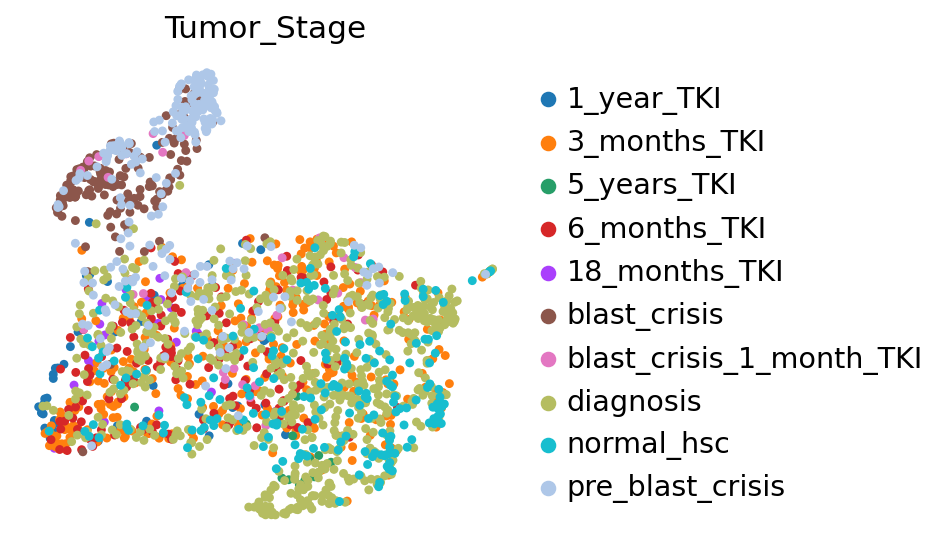

In [12]:
sc.pl.umap(
    adata,
    color="Tumor_Stage",
    frameon=False,
)

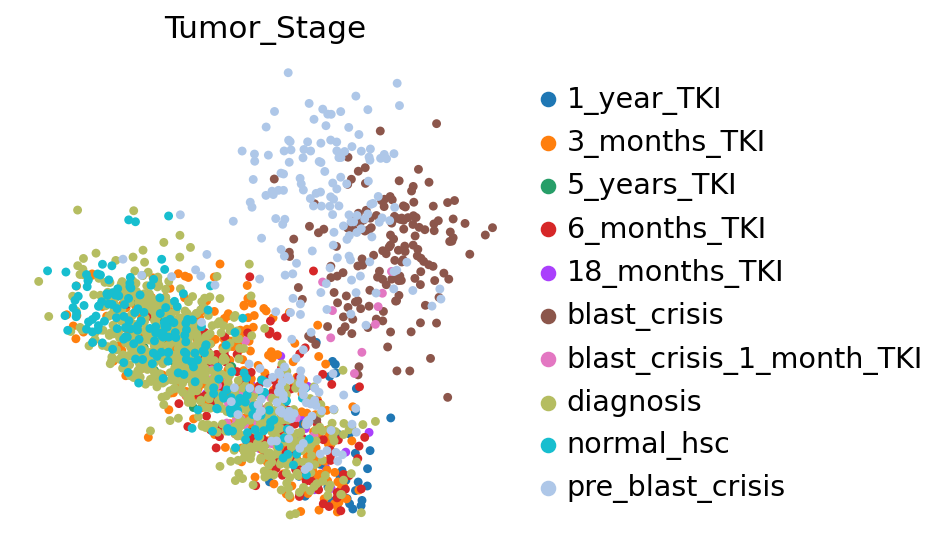

In [13]:
sc.pl.pca(
    adata,
    color="Tumor_Stage",
    frameon=False,
)

In [14]:
model.save("myeloid_leukemia_scvi5/")
adata.write_csvs('myeloid_leukemia_scvi5_anndata')

scvi_rd = pd.DataFrame(adata.obsm['X_scVI'])
scvi_rd.index = adata.obs.index
scvi_rd.columns = ['scvi_' + str(x) for x in range(1, 6)]

scvi_rd.to_csv('myeloid_leukemia_scvi5_rd.tab', sep='\t', index=True, header=True)

writing .csv files to myeloid_leukemia_scvi5_anndata


In [11]:
meta.index[meta.Tumor_Stage != 'Cell line']

Index(['SRR3052083', 'SRR3052084', 'SRR3052085', 'SRR3052086', 'SRR3052087',
       'SRR3052088', 'SRR3052089', 'SRR3052090', 'SRR3052091', 'SRR3052092',
       ...
       'SRR5290522', 'SRR5290523', 'SRR5290524', 'SRR5290525', 'SRR5290526',
       'SRR5290527', 'SRR5290528', 'SRR5290529', 'SRR5290530', 'SRR5290531'],
      dtype='object', name='Run', length=2198)

In [12]:
meta.index

Index(['SRR3052037', 'SRR3052038', 'SRR3052039', 'SRR3052040', 'SRR3052041',
       'SRR3052042', 'SRR3052043', 'SRR3052044', 'SRR3052045', 'SRR3052046',
       ...
       'SRR5290522', 'SRR5290523', 'SRR5290524', 'SRR5290525', 'SRR5290526',
       'SRR5290527', 'SRR5290528', 'SRR5290529', 'SRR5290530', 'SRR5290531'],
      dtype='object', name='Run', length=2289)

In [18]:
model.save("myeloid_leukemia/")

scvi_rd = pd.DataFrame(adata.obsm['X_scVI'])
scvi_rd.index = adata.obs.index
scvi_rd.columns = ['scvi_' + str(x) for x in range(1, 11)]

scvi_rd.to_csv('ml_scvi_rd.tab', sep='\t', index=True, header=True)

In [19]:
rd.shape

(1881, 5)

In [20]:
scvi_rd.shape

(1881, 10)